# Task 1: Forecasting
The main goal of this block is to implement a system for forecasting demand for a short-term period (14 days) 7 days after the last date in the data, for all product groups. We base it on the transaction data provided to you. It is important to take into account that the system can issue a forecast for new products (which had little or no data during training). We would like to see 2 approaches for comparison: using machine learning and classical time series forecasting. 

The technical solution should be substantiated with comments on the feasibility of a particular method or approach.
As a result: A file (.py/.ipynb) with a technical solution for forecasting. This functionality should be able to calculate the result for the future period (scoring).

In [1]:
!pip install pmdarima --quiet

In [2]:
!pip install lightgbm --quiet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import MeanSquaredError

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from lightgbm import LGBMRegressor

from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [4]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
from prepare import *

In [6]:
data_dir = 'S_Data/'
dicts_dir = 'S_Data/dicts/'

data = get_data(data_dir)
dicts = get_data(dicts_dir, sep=';')

In [7]:
df_orders = data['orders']
df_payments = data['order_payments']
df_order_items = data['order_items']
df_products = data['products']

In [8]:
products_dict = data['product_category_name_translation']
products_dict = dict(zip(products_dict['product_category_name'], products_dict['product_category_name_english']))

# EDA

Since the assignment specifies that we should base our work on transaction data, let's take the order IDs from the transactions table and use those, meaning the orders that have been confirmed and paid for:

In [9]:
payed_orders_ids = df_payments['order_id'].unique()

Let's look at the distribution of the number of orders by status to understand whether we need to filter them by status:

In [10]:
df_orders[df_orders['order_id'].isin(payed_orders_ids)]['order_status'].value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

As we can see, about 97% of the orders were successfully delivered. The remaining portions of orders are insignificant, so we can use the entire dataset without filtering by status.

Next, let's see how many product categories are in the dataset and look at the most popular product categories:

In [11]:
print("Amount of unique categories: ", len(df_products['product_category_name'].unique()))

Amount of unique categories:  74


In [12]:
temp_df = df_order_items[df_order_items['order_id'].isin(payed_orders_ids)][['order_id', 'product_id']]

In [14]:
prod_cat_dict = dict(zip(list(df_products['product_id']), list(df_products['product_category_name'])))
temp_df['category'] = temp_df['product_id'].apply(lambda x: prod_cat_dict[str(x)])

In [15]:
temp_df['num_orders'] = np.ones(len(temp_df))
temp_df = temp_df.drop(['order_id', 'product_id'], axis=1).groupby('category').apply(sum).drop('category', axis=1)

In [16]:
top_10 = temp_df.sort_values('num_orders', ascending=False).head(10).reset_index()
top_10['eng_category'] = top_10['category'].apply(lambda x: products_dict[x])
top_10

,category,num_orders,eng_category
0,cama_mesa_banho,11115.0,bed_bath_table
1,beleza_saude,9667.0,health_beauty
2,esporte_lazer,8641.0,sports_leisure
3,moveis_decoracao,8334.0,furniture_decor
4,informatica_acessorios,7827.0,computers_accessories
5,utilidades_domesticas,6964.0,housewares
6,relogios_presentes,5991.0,watches_gifts
7,telefonia,4545.0,telephony
8,ferramentas_jardim,4347.0,garden_tools
9,automotivo,4235.0,auto


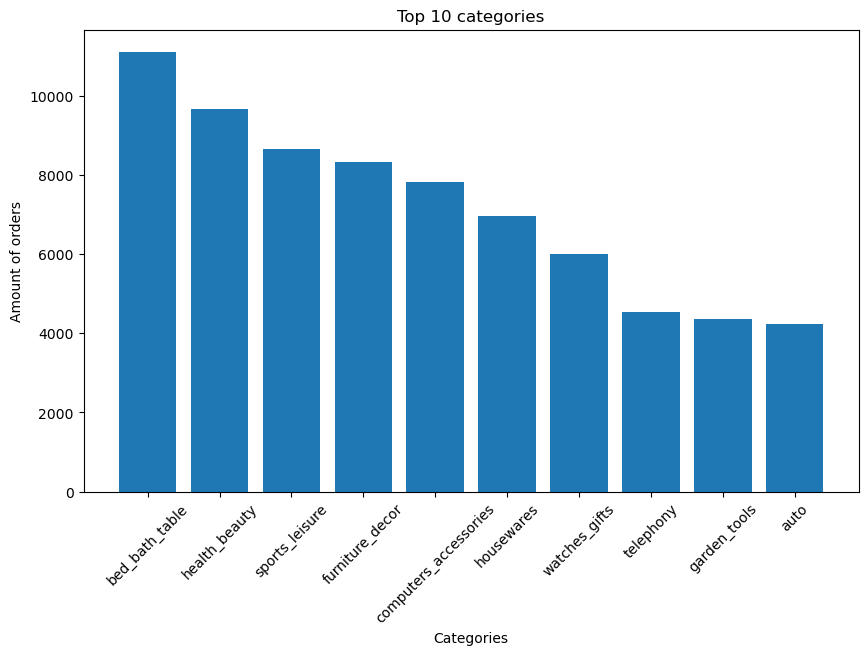

In [17]:
fig = plt.figure(figsize=(10, 6))
plt.bar(top_10['eng_category'], top_10['num_orders'])
plt.xticks(rotation=45)
plt.xlabel('Categories')
plt.ylabel('Amount of orders')
plt.title('Top 10 categories');

As we can see, there are a total of 74 different product categories. The most popular categories are bed_bath_table and health_beauty.

# Task understanding:
So, we need to build models to forecast demand for the short-term period for all product groups. As I understand, we need to build a model to forecast the demand for products in general, not for each category individually. There are 74 categories in total, and I believe it is impractical to build separate models for each product category because constructing separate models would take a lot of time, and automating this process might result in poor quality outcomes.

Demand for a product is defined as the quantity of the product that consumers want and are able to purchase over a specific period. Therefore, the next step is to prepare a time series consisting of the date (we will use daily intervals) and the total number of product units sold during that period. We will consider sold products to be those that were paid for.

Additionally, we can consider building a model to forecast the amount of money flowing through the marketplace's payment system. I believe this could be very useful since marketplaces typically earn profit as a percentage of the value of sold products.

# Preparing time series:
As mentioned earlier, let's prepare the time series:

In [18]:
ts_df = df_order_items[df_order_items['order_id'].isin(payed_orders_ids)][['order_id', 'product_id']]

In [19]:
set(ts_df['order_id']) - set(df_orders['order_id'])

set()

In [22]:
order_time_dict = dict(zip(list(df_orders['order_id']), list(df_orders['order_purchase_timestamp'])))
ts_df['purchase_timestamp'] = ts_df['order_id'].apply(lambda x: order_time_dict[str(x)])

In [23]:
ts_df['num'] = np.ones(len(ts_df))
ts_df.drop(['order_id', 'product_id'], axis=1, inplace=True)
ts_df['purchase_timestamp'] = pd.to_datetime(ts_df['purchase_timestamp']).dt.date
ts_df.head()

,purchase_timestamp,num
0,2017-09-13,1.0
1,2017-04-26,1.0
2,2018-01-14,1.0
3,2018-08-08,1.0
4,2017-02-04,1.0


In [24]:
#orders_ts = ts_df.drop('product_category', axis=1).set_index('purchase_timestamp').groupby('purchase_timestamp').apply(sum)
orders_ts = ts_df.set_index('purchase_timestamp').groupby('purchase_timestamp').apply(sum)
orders_ts.head()

,num
purchase_timestamp,
2016-09-04,2.0
2016-09-05,1.0
2016-10-02,1.0
2016-10-03,8.0
2016-10-04,69.0


In [25]:
orders_ts.index.is_monotonic_increasing

True

In [62]:
#orders_ts.to_csv('PD/prepared_1_1.csv')

orders_ts = pd.read_csv('PD/prepared_1_1.csv')
orders_ts['purchase_timestamp'] = pd.to_datetime(orders_ts['purchase_timestamp']).dt.date
orders_ts.set_index('purchase_timestamp', inplace=True)
orders_ts

,num
purchase_timestamp,
2016-09-04,2.0
2016-09-05,1.0
2016-10-02,1.0
2016-10-03,8.0
2016-10-04,69.0
...,...
2018-08-26,82.0
2018-08-27,71.0
2018-08-28,45.0


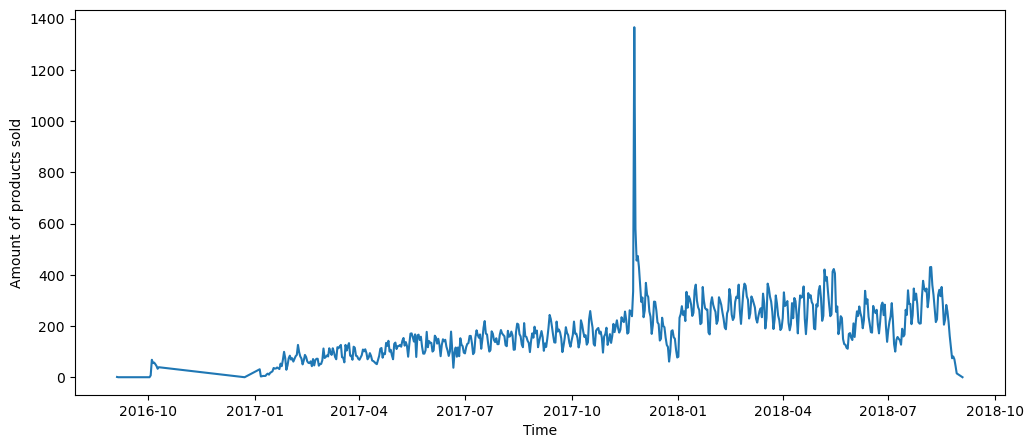

In [63]:
fig = plt.figure(figsize=(12, 5))
plt.plot(pd.to_datetime(orders_ts.index), orders_ts['num'])
plt.xlabel('Time')
plt.ylabel('Amount of products sold');

As you can see from the graph, there may be outliers in the data, which we will identify later. Also, there are missing values in the data (not all dates have sales information). In the next section, we will consider the steps of preliminary processing of the series.

# Preprocessing:
At this stage, it is necessary to preprocess the data: fill in the gaps (the time series should have values at equal time intervals), remove outliers, and select a relevant time period for model building.

## 1. Filling the gaps:
Since we have chosen daily intervals, it is necessary for the data to be filled for each day within our time period. If there is no sales information for a specific day, then I believe it would be fair to fill such places with zeros. If this method of filling gaps results in many outliers, we will smooth them out later.

In [64]:
print("Start date: ", orders_ts.index[0])
print("End date: ", orders_ts.index[-1])

Start date:  2016-09-04
End date:  2018-09-03


Let's generate dates from the initial observation to the last available one:

In [65]:
dates = pd.date_range(start=orders_ts.index[0], end=orders_ts.index[-1], freq="d")
dates

DatetimeIndex(['2016-09-04', '2016-09-05', '2016-09-06', '2016-09-07',
               '2016-09-08', '2016-09-09', '2016-09-10', '2016-09-11',
               '2016-09-12', '2016-09-13',
               ...
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
               '2018-09-02', '2018-09-03'],
              dtype='datetime64[ns]', length=730, freq='D')

We get 730 dates to label the time stamps of the series. The next step is to form the final series and fill in the gaps:

In [66]:
ts = pd.DataFrame({'timestamp': dates})
ts['num'] = ts['timestamp'].dt.date.apply(lambda x: orders_ts.loc[x]['num'] if x in orders_ts.index else 0.)
ts

,timestamp,num
0,2016-09-04,2.0
1,2016-09-05,1.0
2,2016-09-06,0.0
3,2016-09-07,0.0
4,2016-09-08,0.0
...,...,...
725,2018-08-30,0.0
726,2018-08-31,0.0
727,2018-09-01,0.0
728,2018-09-02,0.0


Let's plot the resulting time series:

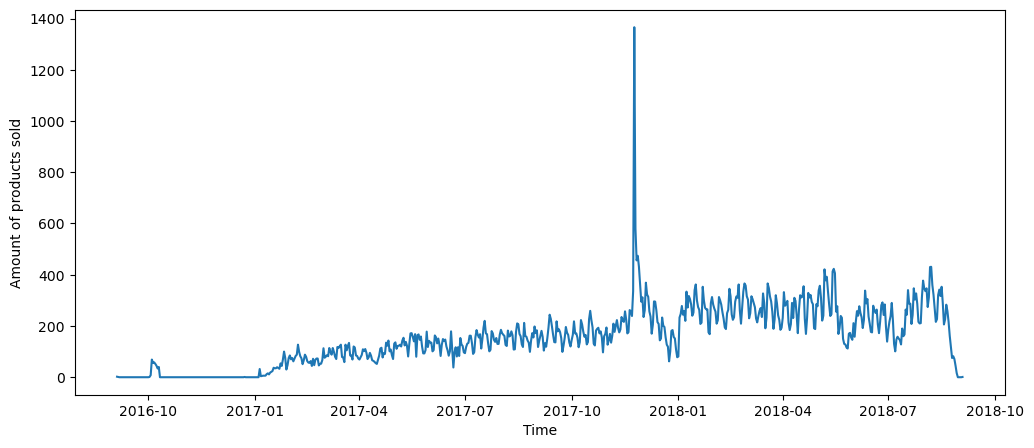

In [67]:
fig = plt.figure(figsize=(12, 5))
plt.plot(ts['timestamp'], ts['num'])
plt.xlabel('Time')
plt.ylabel('Amount of products sold');

In [68]:
#ts.to_csv('PD/prepared_1_2.csv', index=False)

ts = pd.read_csv('PD/prepared_1_2.csv')
ts['timestamp'] = pd.to_datetime(ts['timestamp'])
ts

,timestamp,num
0,2016-09-04,2.0
1,2016-09-05,1.0
2,2016-09-06,0.0
3,2016-09-07,0.0
4,2016-09-08,0.0
...,...,...
725,2018-08-30,0.0
726,2018-08-31,0.0
727,2018-09-01,0.0
728,2018-09-02,0.0


## 2. Processing of extreme values:

First, let's see if the previously obtained data really has outliers: for this purpose we use the interquartile range (IQR) method:

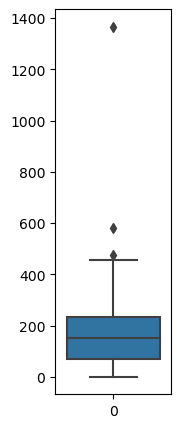

In [69]:
fig = plt.figure(figsize=(1.5, 5))
sns.boxplot(ts['num']);

In [70]:
Q1 = ts['num'].quantile(0.25)
Q3 = ts['num'].quantile(0.75)

IQR = Q3 - Q1

interval_lower_bound = Q1 - 1.5*IQR
interval_upper_bound = Q3 + 1.5*IQR

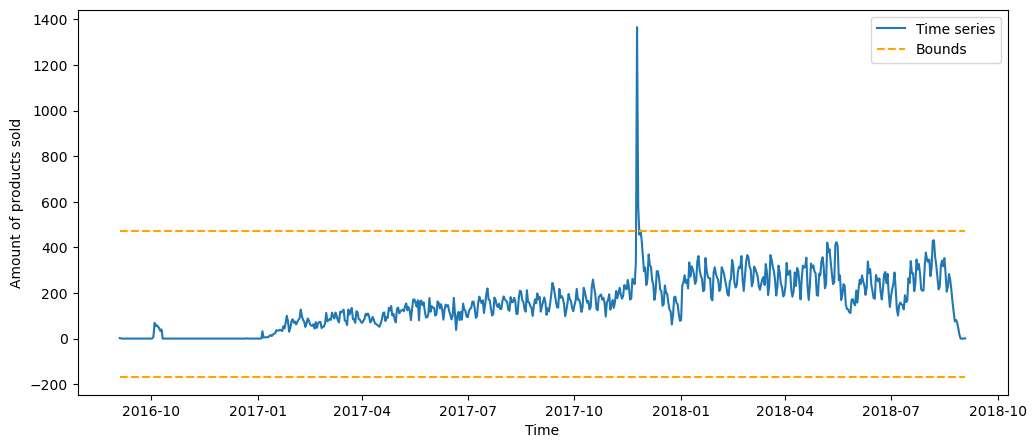

In [71]:
fig = plt.figure(figsize=(12, 5))
plt.plot(ts['timestamp'], ts['num'], label='Time series')
plt.plot(ts['timestamp'], np.ones(730)*interval_upper_bound, linestyle='--', color='orange', label='Bounds')
plt.plot(ts['timestamp'], np.ones(730)*interval_lower_bound, linestyle='--', color='orange')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

Based on the results of the above graphs, we can realize that there are definitely outliers in the data and something needs to be done about them.

This “spike” is not a measurement error, but rather an event that cannot be predicted, so we need to get rid of it. To do this, we simply trim the values of the series by the obtained intervals:

In [72]:
tts = ts.copy()
tts['clipped_num'] = np.clip(list(tts['num']), interval_lower_bound, interval_upper_bound)
#tts.drop('num', axis=1, inplace=True)

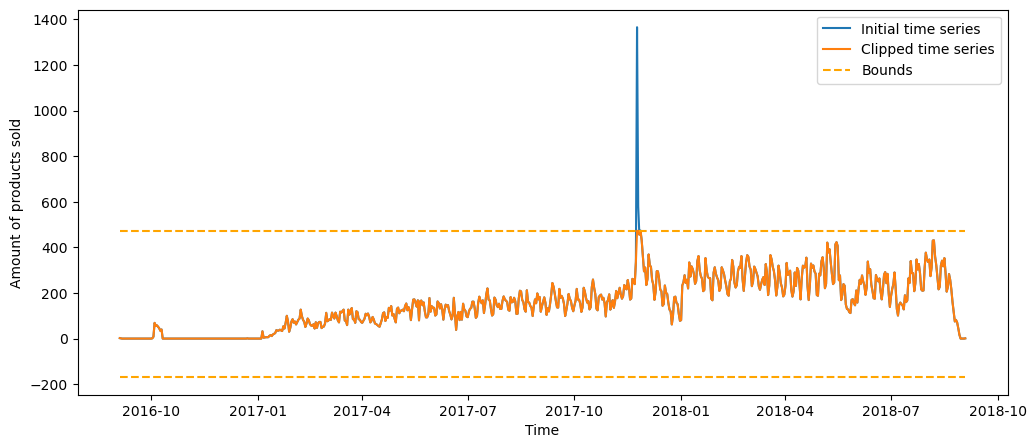

In [73]:
fig = plt.figure(figsize=(12, 5))
plt.plot(tts['timestamp'], tts['num'], label='Initial time series')
plt.plot(tts['timestamp'], tts['clipped_num'], label='Clipped time series')
plt.plot(tts['timestamp'], np.ones(730)*interval_upper_bound, linestyle='--', color='orange', label='Bounds')
plt.plot(tts['timestamp'], np.ones(730)*interval_lower_bound, linestyle='--', color='orange')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

Now we can proceed to the last stage of series preprocessing: selecting a subset of values of the series to build a model on it.

## 3. Choosing the relevant TS subset:
We can see that at the initial stage there were no or few sales. This long period of time is of no value for model building, so we can safely get rid of it. Let's cut the series starting from about January 2017 until the last date:

In [74]:
res_ts = tts[tts['timestamp'] >= '2017-01-01'].drop('num', axis=1)

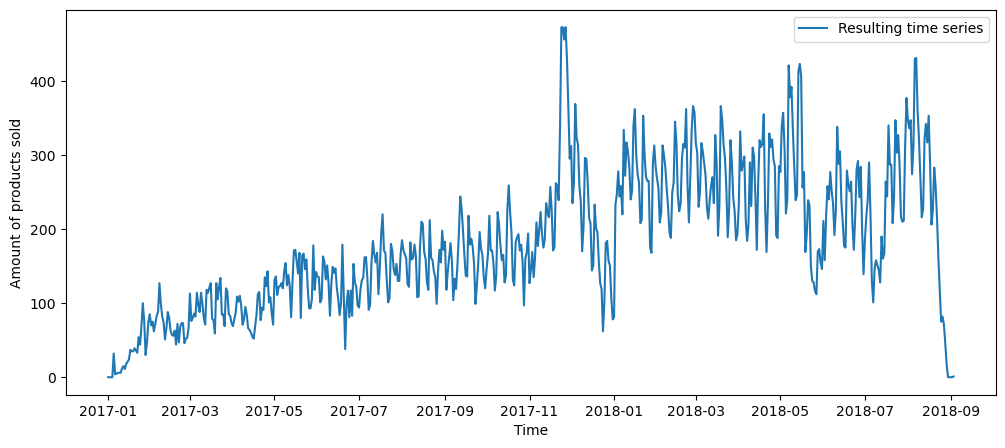

In [75]:
fig = plt.figure(figsize=(12, 5))
plt.plot(res_ts['timestamp'], res_ts['clipped_num'], label='Resulting time series')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

## 4. Exponential smoothing:
Our series has very strong fluctuations, so we will apply the exponential smoothing method to obtain a more stable series that will be easier to predict in the future. After all, we are mostly interested in the overall behavior of the series, not in each deviation.

In [76]:
exp_smooth = SimpleExpSmoothing(res_ts.set_index('timestamp'), initialization_method="heuristic").fit(
    smoothing_level=0.5, optimized=False
)

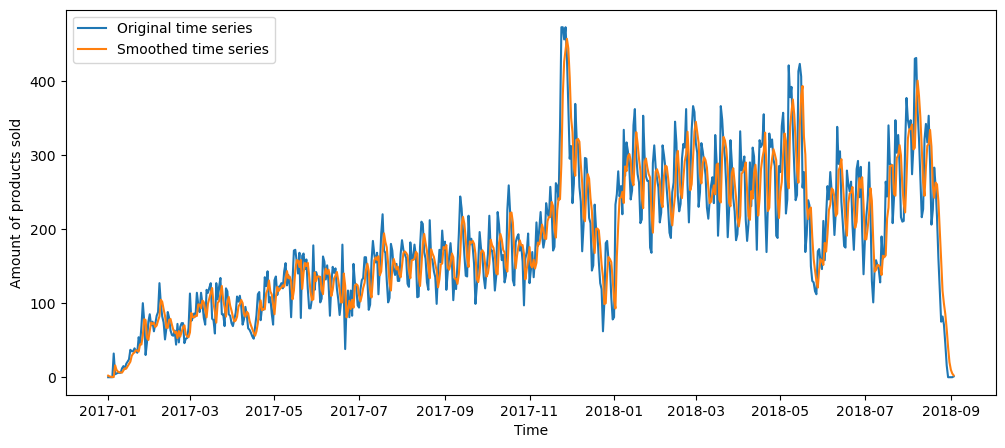

In [77]:
fig = plt.figure(figsize=(12, 5))
plt.plot(pd.to_datetime(res_ts['timestamp']).dt.date, res_ts['clipped_num'], label='Original time series')
plt.plot(exp_smooth.fittedvalues, label='Smoothed time series')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

In [78]:
res_ts = exp_smooth.fittedvalues
res_ts.dropna(inplace=True)
res_ts

timestamp
2017-01-01     2.133333
2017-01-02     1.066667
2017-01-03     0.533333
2017-01-04     0.266667
2017-01-05     0.133333
                ...    
2018-08-30    40.540389
2018-08-31    20.270195
2018-09-01    10.135097
2018-09-02     5.067549
2018-09-03     2.533774
Length: 611, dtype: float64

In [79]:
#res_ts.to_csv('PD/prepared_1_f.csv')

res_ts = pd.read_csv('PD/prepared_1_f.csv')
res_ts['timestamp'] = pd.to_datetime(res_ts['timestamp'])
res_ts.set_index('timestamp', inplace=True)
res_ts = res_ts['0']
res_ts

timestamp
2017-01-01     2.133333
2017-01-02     1.066667
2017-01-03     0.533333
2017-01-04     0.266667
2017-01-05     0.133333
                ...    
2018-08-30    40.540389
2018-08-31    20.270195
2018-09-01    10.135097
2018-09-02     5.067549
2018-09-03     2.533774
Name: 0, Length: 611, dtype: float64

# Modeling:

## Approach 1: Time Series Analysis

### 1.1. Time series stationarity

From the graph of our time series we can see that the fluctuations become stronger over time. This may indicate that the time series is non-stationary. Let's test this hypothesis using Augmented Dickey-Fuller test:

In [80]:
result = adfuller(res_ts)

print("ADF statisctics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])
print("Lags used: ", result[2])
print("Number of observations used: ", result[3])

ADF statisctics:  -2.942796703515394
p-value:  0.040592880785746
Critical values:  {'1%': -3.441388211993052, '5%': -2.8664097967491498, '10%': -2.569363480686392}
Lags used:  15
Number of observations used:  595


According to the test results, we should reject the null hypothesis with a significance level of 0.05 that the series is non-stationary, but the p-value is too high to confidently reject the null hypothesis. Let us refine the result using the Kwiatkowski-Phillips-Schmidt-Shin test:

In [81]:
result = kpss(res_ts)

print("KPSS statisctics: ", result[0])
print("p-value: ", result[1])
print("Lags used: ", result[2])
print("Critical values: ", result[3])

KPSS statisctics:  2.6168679882686097
p-value:  0.01
Lags used:  16
Critical values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Here we can confidently reject the null hypothesis with a significance level of 0.05 that the series is stationary and take into account that the series is non-stationary.

### 1.2. Train-test split
We split our sample into a training and a test subset (90/10). 

In [82]:
train_size = 0.9
data_size = len(res_ts)
split_point = int(data_size*train_size)

ts_train = res_ts.iloc[:split_point]
ts_test = res_ts.iloc[split_point:]

In [83]:
test_start_date = ts_test.index[0]
test_end_date = ts_test.index[-1]

print("Test start date: ", test_start_date)
print("Test end date: ", test_end_date)

Test start date:  2018-07-04 00:00:00
Test end date:  2018-09-03 00:00:00


In [84]:
train_start_date = ts_train.index[0]
train_end_date = ts_train.index[-1]

print("Train start date: ", train_start_date)
print("Train end date: ", train_end_date)

Train start date:  2017-01-01 00:00:00
Train end date:  2018-07-03 00:00:00


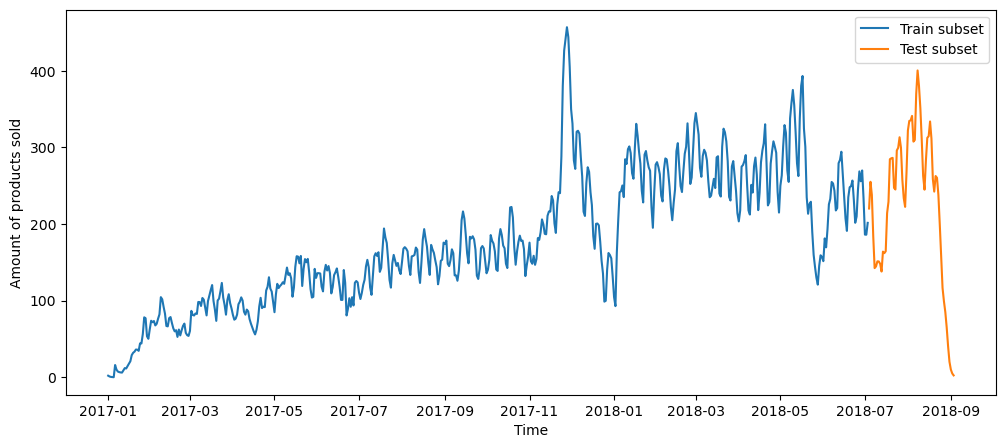

In [85]:
fig = plt.figure(figsize=(12, 5))
plt.plot(ts_train, label='Train subset')
plt.plot(ts_test, label='Test subset')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

### Here we can see that the behavior of the series on the test sample is too unpredictable for the model trained on the training sample to be able to correctly predict the values of the test sample, much less to make a qualitative prediction after it. Therefore, we will leave the series without partitioning, and train the model using the walk-forward validation method, i.e., on the entire data set.

### 1.3. TS decomposition
Let us decompose the time series. Since we already know that the series is not stationary, and even purely visually it is clear that the variance depends to some extent on the values of the series at any given time, we apply multiplicative decomposition.

Since multiplicative decomposition does not work with zero values, add 1 to all values of the series.

In [86]:
res_ts_ = res_ts + 1

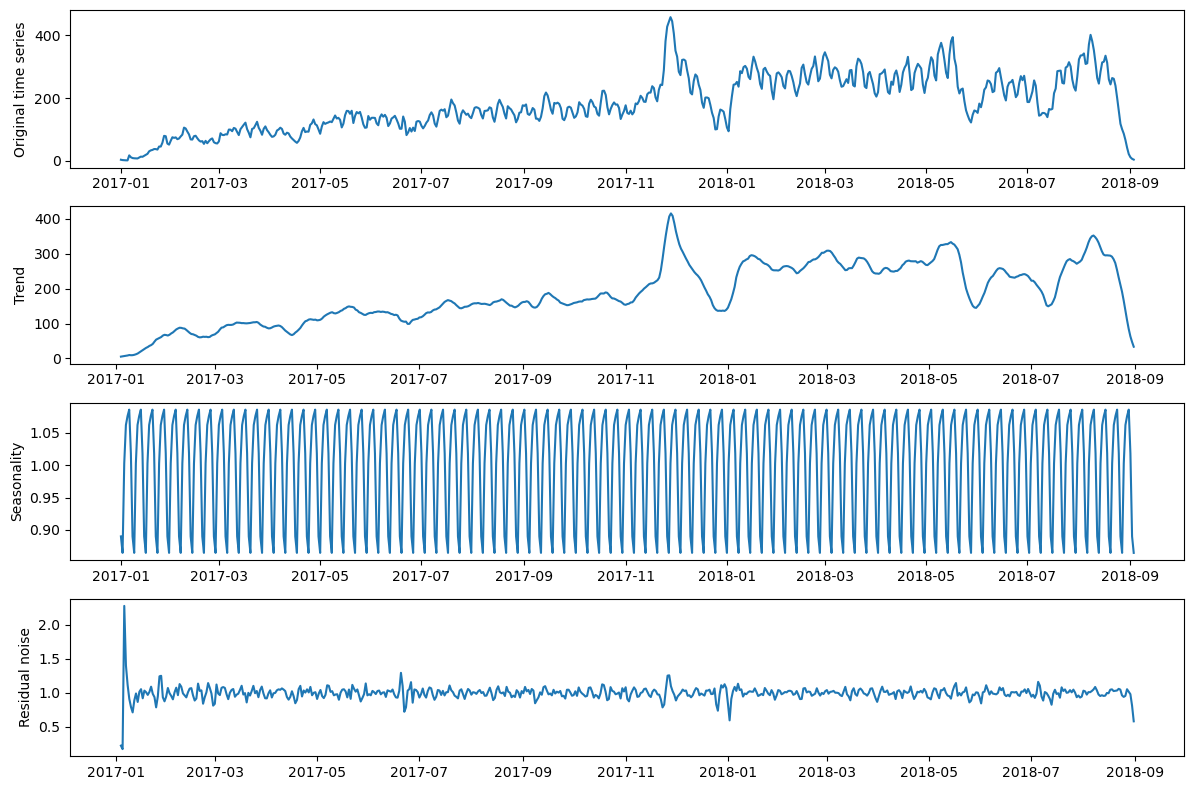

In [87]:
result = seasonal_decompose(res_ts_, model='multiplicative')

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(res_ts_)
plt.ylabel('Original time series')

plt.subplot(412)
plt.plot(result.trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(result.seasonal)
plt.ylabel('Seasonality')

plt.subplot(414)
plt.plot(result.resid)
plt.ylabel('Residual noise')

plt.tight_layout()
plt.show()

As we can see, we have a trend (it can be ignored in the process of model building, because our task is to forecast for a short-term period), seasonal fluctuations (weekly). The residuals look like white noise, which means that the decomposition is done correctly and we can proceed to the model selection stage.

### 1.4. Choosing model
So, the trend should not be removed, as it may be useful for the model. We will consider autoregressive models, possibly with a moving average, most likely which take into account seasonality and trend (e.g. ARIMA).

Let's find out the order of differentiation, at which the series becomes stationary:

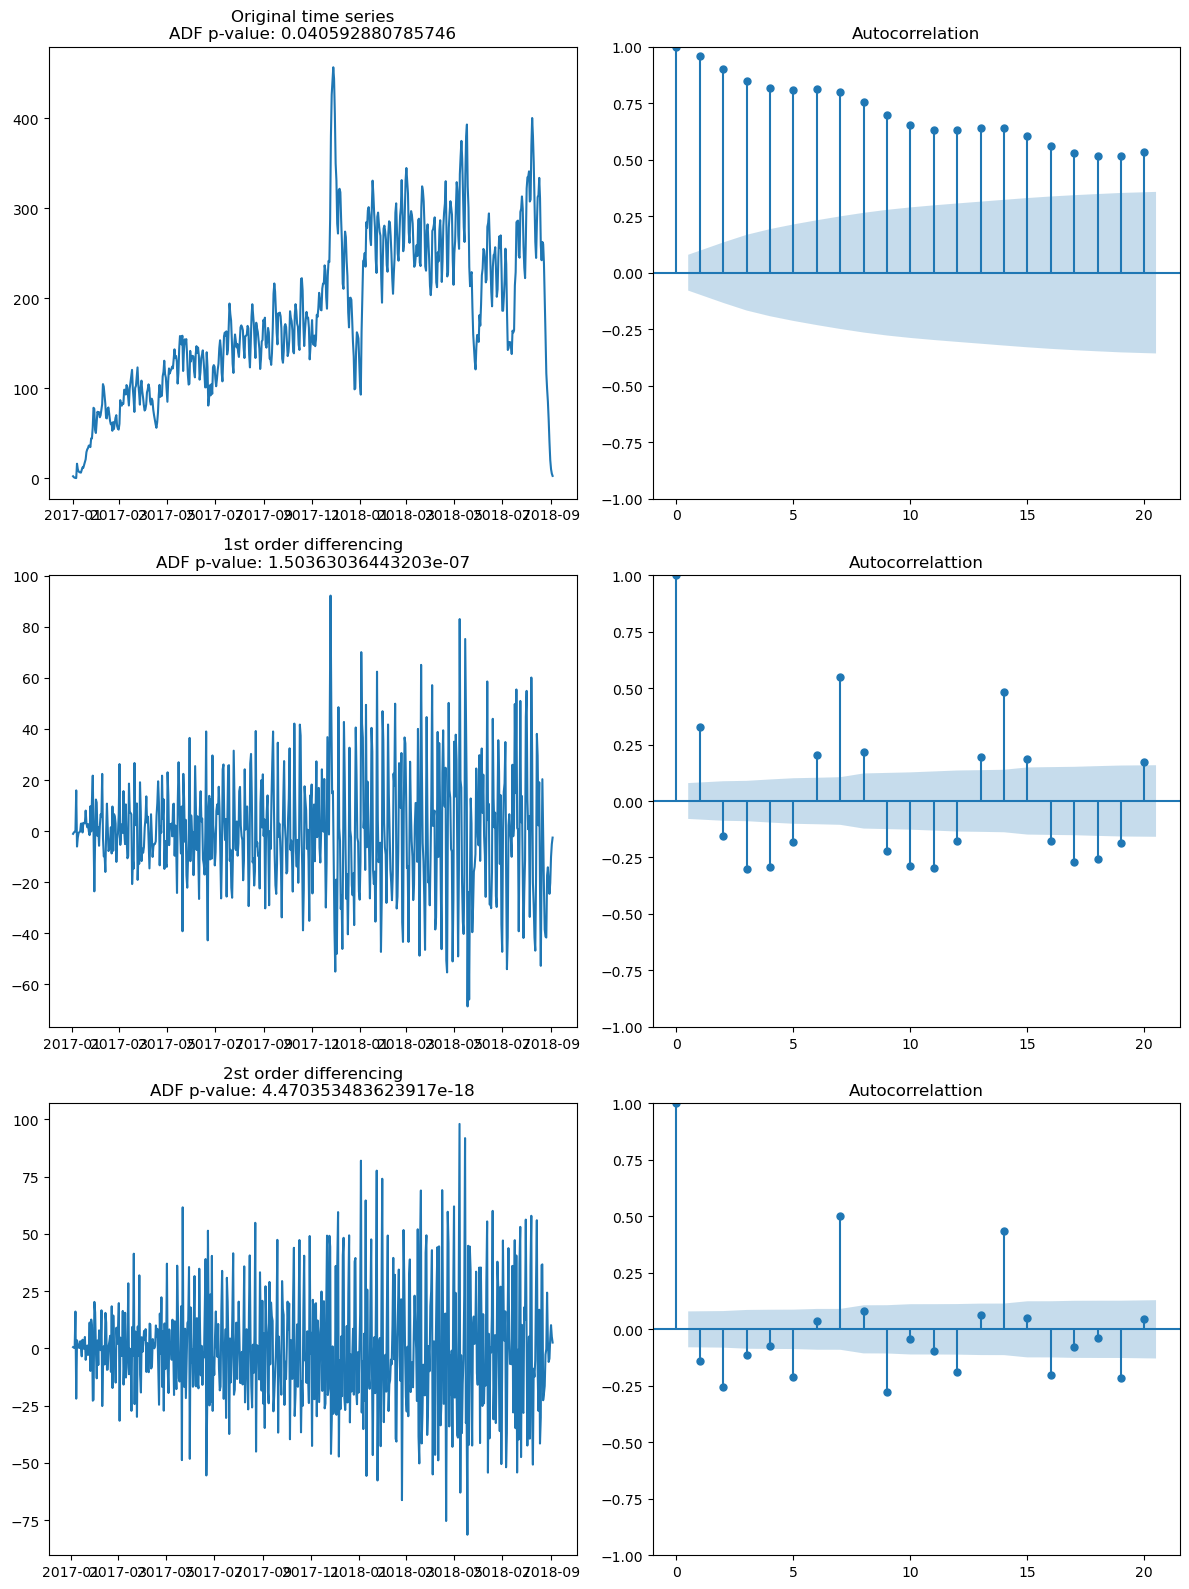

In [88]:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

adf_result = adfuller(res_ts)
axes[0, 0].plot(res_ts)
axes[0, 0].set_title(f'Original time series\nADF p-value: {adf_result[1]}')
plot_acf(res_ts, lags=20, ax=axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

temp = res_ts.copy()
for i in range(1, 3):
    temp = temp.diff().dropna()
    adf_result = adfuller(temp.dropna())
    axes[i, 0].plot(temp)
    axes[i, 0].set_title(f"{i}st order differencing\nADF p-value: {adf_result[1]}")
    plot_acf(temp, lags=20, ax=axes[i, 1])
    axes[i, 1].set_title('Autocorrelattion')

plt.tight_layout()
plt.show()

As can be seen, the first order of differentiation is sufficient to obtain a stationary series.

Let us look at the graph of the autocorrelation function and partial autocorrelation function after differentiation of order 1:

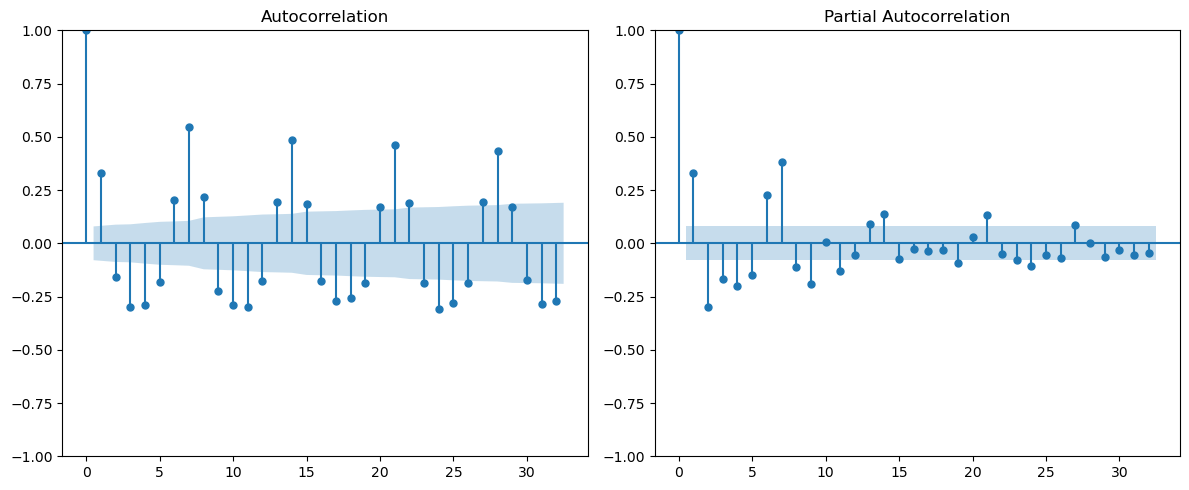

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(res_ts.diff().dropna(), lags=32, ax=ax1)
plot_pacf(res_ts.diff().dropna(), lags=32, ax=ax2)

plt.tight_layout()
plt.show()

We use an automatic search for the best model parameters:

In [90]:
model = auto_arima(res_ts, seasonal=True, m=7)
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  611
Model:             SARIMAX(3, 1, 2)x(2, 0, [1], 7)   Log Likelihood               -2556.725
Date:                             Wed, 15 May 2024   AIC                           5133.450
Time:                                     16:39:39   BIC                           5177.585
Sample:                                 01-01-2017   HQIC                          5150.618
                                      - 09-03-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.478e-05      0.001      0.075      0.940      -0.001       0.001
ar.L1          0.2789      

We will test the quality of the model on the training data:

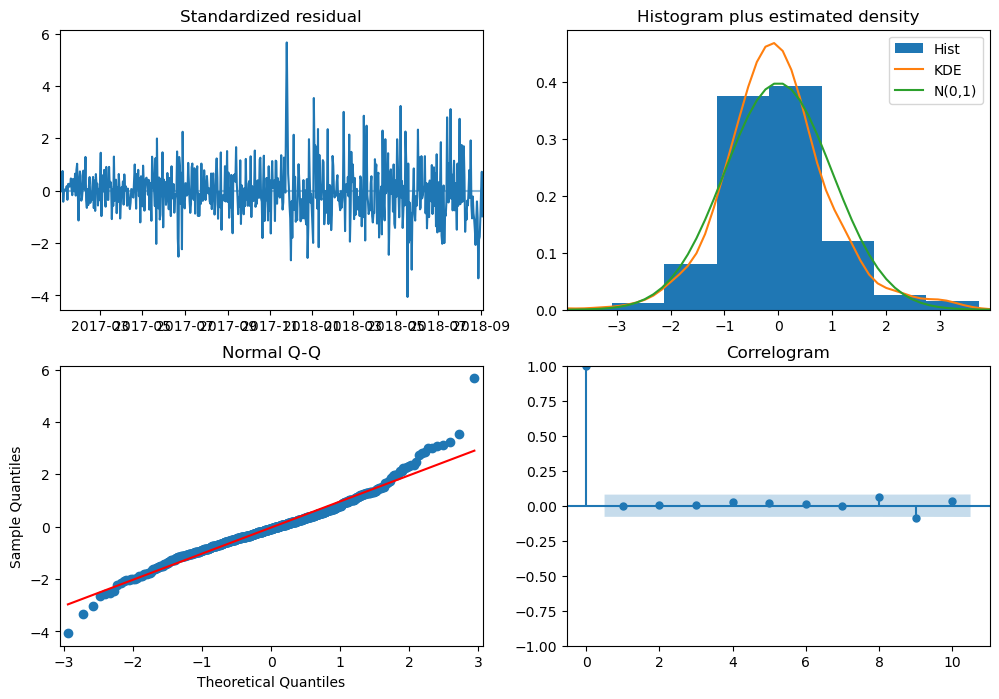

In [91]:
model.plot_diagnostics(figsize=(12, 8))
plt.show()

The residuals appear to be white noise with 95% probability.

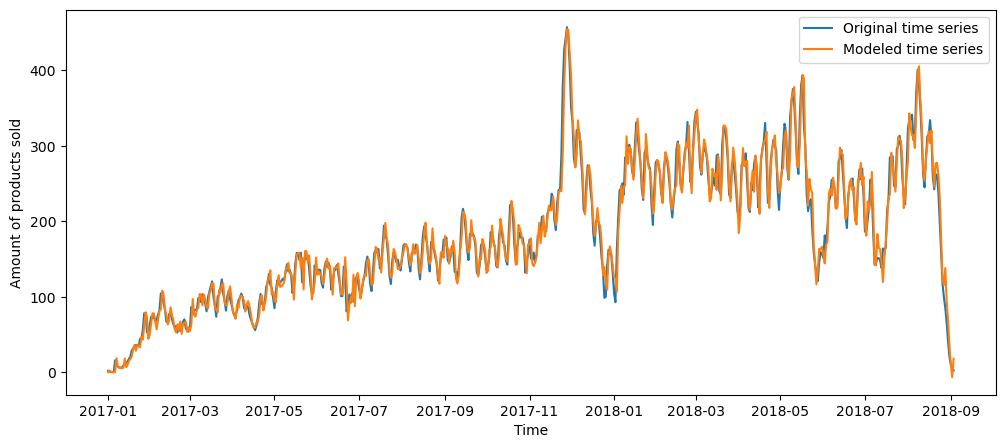

In [92]:
predict = model.predict_in_sample()
fig = plt.figure(figsize=(12, 5))

plt.plot(res_ts, label='Original time series')
plt.plot(predict, label='Modeled time series')

plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

Let's derive the main metrics for assessing the quality of the model:

In [93]:
R_squared = r2_score(res_ts, predict)
MSE = mean_squared_error(res_ts, predict)

print("R^2 = ", R_squared)
print("MSE = ", MSE)

R^2 =  0.9681405300583674
MSE =  251.59139890464536


The coefficient of determination has a value of 0.967, indicating that the model fits the data well.

Let's analyze the residuals: we need to make sure that they are white noise:

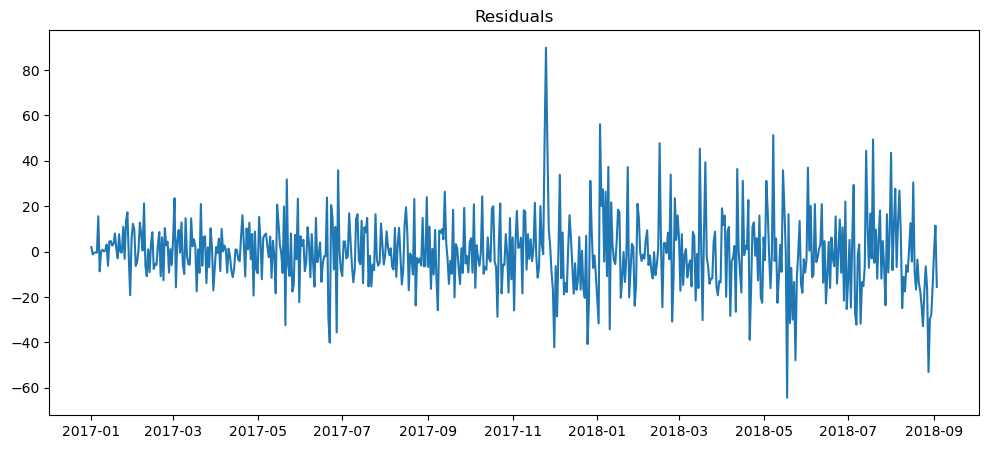

In [94]:
residuals = res_ts - predict

fig = plt.figure(figsize=(12, 5))
plt.plot(residuals)
plt.title(f"Residuals");

In [95]:
print("Durbin-Watson statistic: ", durbin_watson(residuals))

Durbin-Watson statistic:  2.000933919052185


As we can see, the coefficient is close to 2, which means that there is no autocorrelation in the residuals. This means that the residuals are white noise, and the model takes into account all parameters significant for the described process.

### 1.5. Forecast

In [96]:
forecasted_values, confidence_intervals = model.predict(n_periods=21, return_conf_int=True, alpha=0.05)

lower_bound = pd.DataFrame(confidence_intervals[:, 0], index=forecasted_values.index)
upper_bound = pd.DataFrame(confidence_intervals[:, 1], index=forecasted_values.index)

In [97]:
lower_bound[0] = np.clip(list(lower_bound[0]), 0, max(lower_bound[0]))

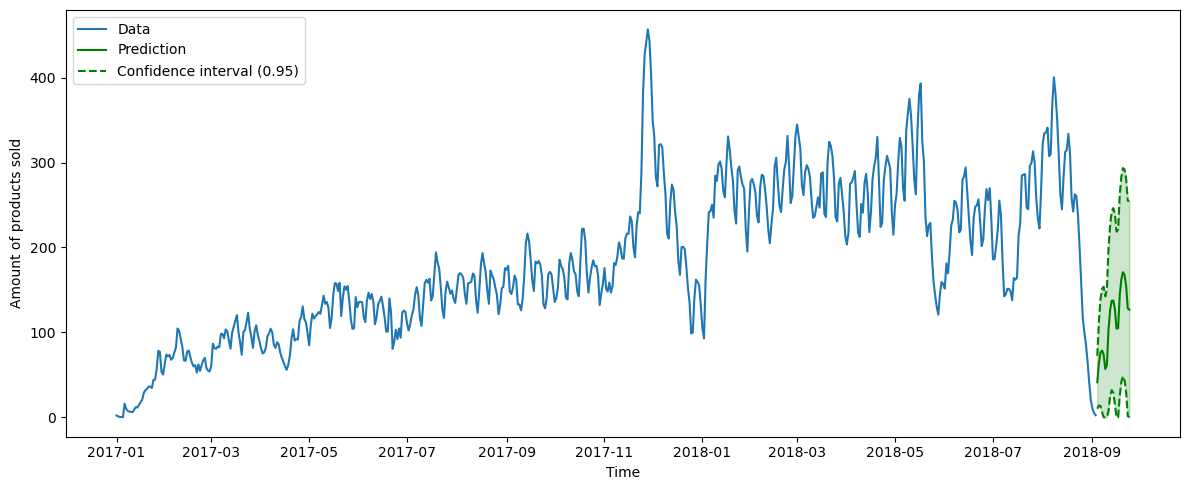

In [98]:
fig = plt.figure(figsize=(12, 5))
plt.plot(res_ts, label='Data')
plt.plot(forecasted_values, color='green', label='Prediction')
plt.plot(lower_bound[0], color='green', linestyle='--', label='Confidence interval (0.95)')
plt.plot(upper_bound[0], color='green', linestyle='--')
plt.fill_between(forecasted_values.index, lower_bound[0], upper_bound[0], color='green', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
fig.tight_layout()
plt.legend();

Let's take a small section at the end of the time series to take a closer look at the forecast:

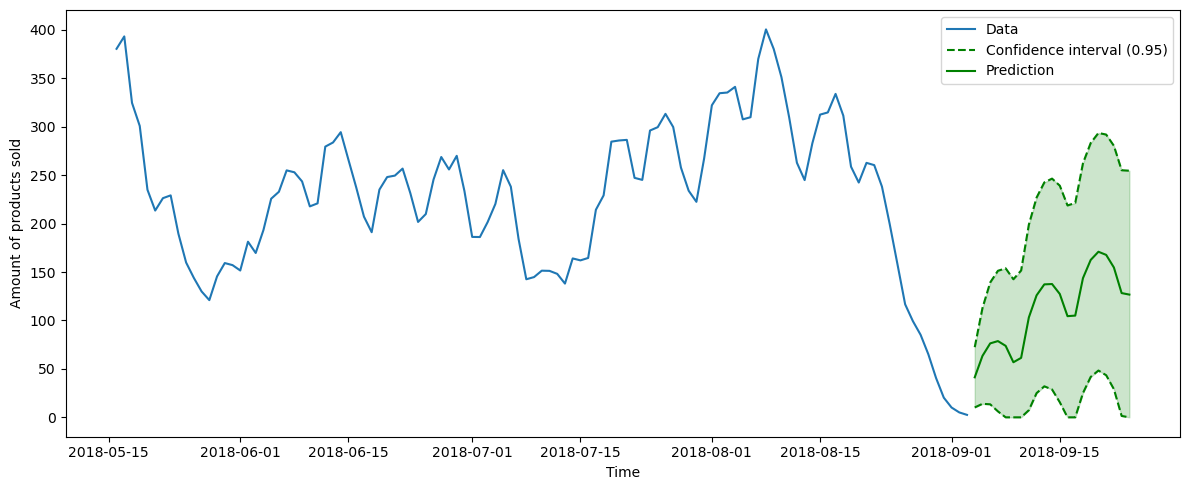

In [99]:
fig = plt.figure(figsize=(12, 5))
plt.plot(res_ts[500:], label='Data')
plt.plot(lower_bound[0], color='green', linestyle='--', label='Confidence interval (0.95)')
plt.plot(upper_bound[0], color='green', linestyle='--')
plt.fill_between(forecasted_values.index, lower_bound[0], upper_bound[0], color='green', alpha=0.2)
plt.plot(forecasted_values, color='green', label='Prediction')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
fig.tight_layout()
plt.legend();

## Approach 2: Machine Learning

In [100]:
res_ts = pd.read_csv('PD/prepared_1_f.csv')
res_ts['timestamp'] = pd.to_datetime(res_ts['timestamp'])
res_ts.set_index('timestamp', inplace=True)
res_ts = res_ts['0']
res_ts

timestamp
2017-01-01     2.133333
2017-01-02     1.066667
2017-01-03     0.533333
2017-01-04     0.266667
2017-01-05     0.133333
                ...    
2018-08-30    40.540389
2018-08-31    20.270195
2018-09-01    10.135097
2018-09-02     5.067549
2018-09-03     2.533774
Name: 0, Length: 611, dtype: float64

### 2.1. Additional data analysis:

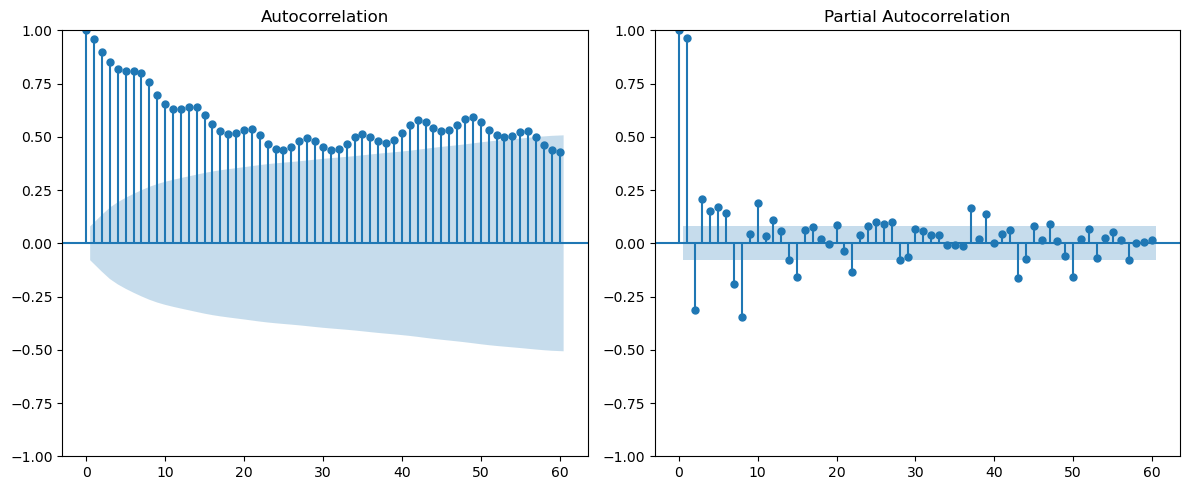

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(res_ts, lags=60, ax=ax1)
plot_pacf(res_ts, lags=60, ax=ax2)

plt.tight_layout()
plt.show()

Since we are going to work with machine learning models that do not process individual components of a time series, we will have to experiment with the number of past values that are taken into account.

### 2.2. Data preparation:

### Train-test split
Let's write a couple of functions to organize the data set for model training. Split the set into training and test samples, build a couple of models, make a prediction on the test sample, select the best model, then further train the model on the test data and finally make a prediction according to the problem.

In [102]:
def get_dataset(time_series:pd.Series, window_size):
    values = list(time_series)
    n = len(values)
    
    X = []
    Y = []
    
    for i in range(n - window_size):
        X.append(values[i:i + window_size])
        Y.append(values[i + window_size])
        
    return np.array(X), np.array(Y)

def get_prediction(model, periods, initial_values:pd.Series, reshape=0):
    x_pred = [list(initial_values)]
    predicts = []
    
    for i in range(periods):
        if reshape:
            pred = model.predict(np.array([[x_pred[i]]]).reshape((1, len(list(initial_values)), 1)), verbose=0)[0]
        else:
            pred = model.predict(np.array([x_pred[i]]))
        predicts.append(pred)
        new_x = x_pred[i][1:]
        new_x.append(pred[0])
        x_pred.append(new_x)
        
    return predicts

def print_metrics(train, test, pred_train, pred_test):
    print("================== Train ==================")
    print("R^2 = ", r2_score(train, pred_train))
    print("MSE = ", mean_squared_error(train, pred_train))
    
    print("\n================== Test ===================")
    print("MSE = ", mean_squared_error(test, pred_test))

In [103]:
train_size = 0.7
data_size = len(res_ts)
split_point = int(data_size*train_size)

ts_train = res_ts.iloc[:split_point]
ts_test = res_ts.iloc[split_point:]

lags = 40

X_train, y_train = get_dataset(ts_train, lags)

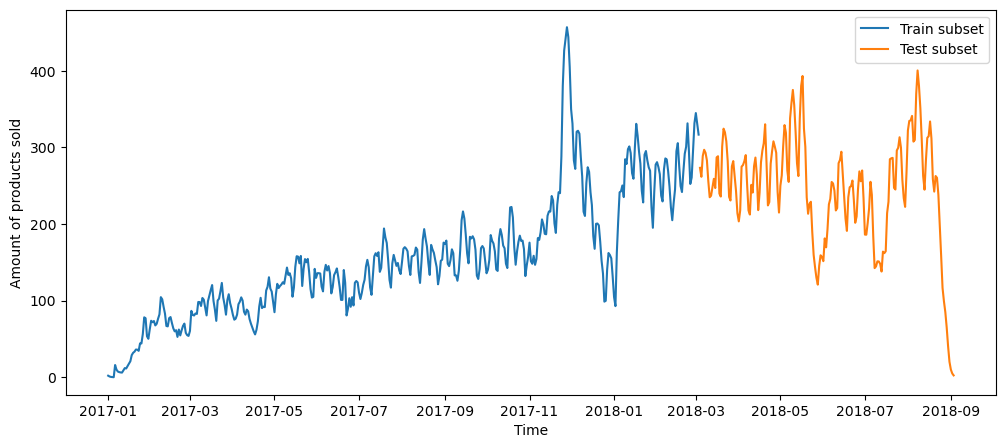

In [104]:
fig = plt.figure(figsize=(12, 5))
plt.plot(ts_train, label='Train subset')
plt.plot(ts_test, label='Test subset')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

### 2.3. Modeling:
Let us start with a random forest model for regression problems. We will obtain all forecasts sequentially, forecasting one value at a time and using it for the next forecasts.

### Random Forest

In [105]:
rfr = RandomForestRegressor(n_estimators=500, random_state=42).fit(X_train, y_train)

In [106]:
train_predict = get_prediction(rfr, len(ts_train[lags:]), ts_train[:lags]) #rfr.predict(X_train)
test_predict = get_prediction(rfr, len(ts_test), ts_train[-lags:])

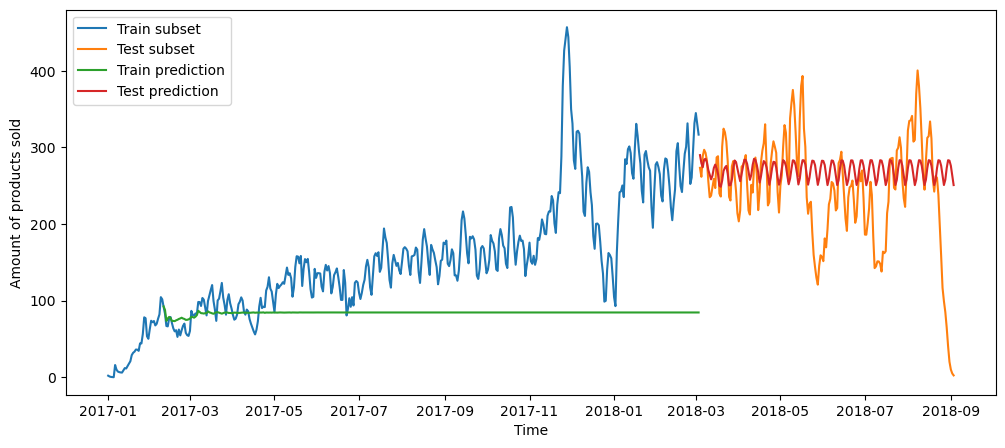

In [107]:
fig = plt.figure(figsize=(12, 5))
plt.plot(ts_train, label='Train subset')
plt.plot(ts_test, label='Test subset')
plt.plot(ts_train.index[lags:], train_predict, label='Train prediction')
plt.plot(ts_test.index, test_predict, label='Test prediction')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

In [108]:
print_metrics(ts_train[lags:], ts_test, train_predict, test_predict)

================== Train ==================
R^2 =  -1.1968026823112217
MSE =  12342.414110793528

================== Test ===================
MSE =  5418.195474383028


As we can see, the model's predictions on the test sample are rather naive. The model is poor at capturing long-term dependencies, but it copes well with seasonal fluctuations. Let's try the LGBM model.

### LGBM

In [109]:
lgbmr = LGBMRegressor(
    boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.2, n_estimators=1000, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.15, random_state=42, n_jobs=4, importance_type='split'
).fit(X_train, y_train)

train_predict = get_prediction(lgbmr, len(ts_train[lags:]), ts_train[:lags]) #lgbmr.predict(X_train)
test_predict = get_prediction(lgbmr, len(ts_test), ts_train[-lags:])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5200
[LightGBM] [Info] Number of data points in the train set: 387, number of used features: 40
[LightGBM] [Info] Start training from score 166.704381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

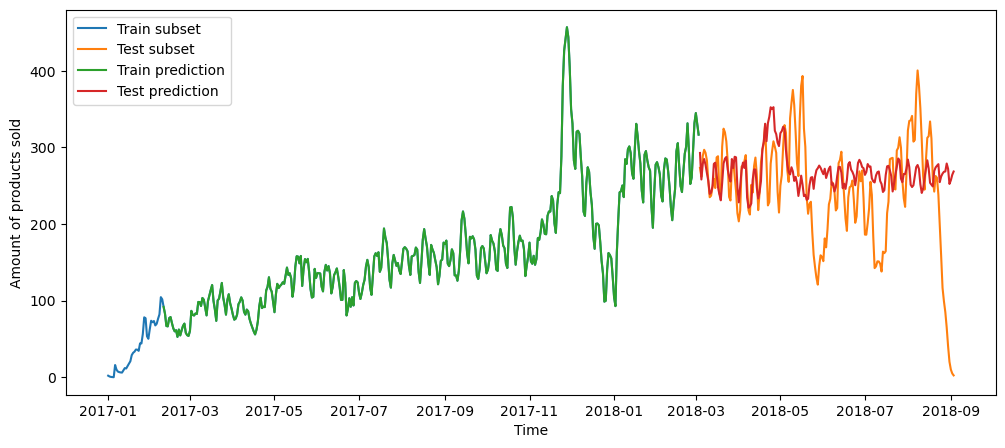

In [110]:
fig = plt.figure(figsize=(12, 5))
plt.plot(ts_train, label='Train subset')
plt.plot(ts_test, label='Test subset')
plt.plot(ts_train.index[lags:], train_predict, label='Train prediction')
plt.plot(ts_test.index, test_predict, label='Test prediction')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

In [111]:
print_metrics(ts_train[lags:], ts_test, train_predict, test_predict)

================== Train ==================
R^2 =  0.9999999997747137
MSE =  1.2657382677382714e-06

================== Test ===================
MSE =  5614.337362456615


This model performed much better on the training data, but there is a problem with the test data. The excellent performance of the model on the training sample may be indicative of overtraining, since the prediction on the training sample was consistent. We should only be interested in a small prediction interval (21 days), so we can conclude that this model is probably the best fit for us. But we should try some other models. Let's take something more powerful: a recurrent neural network like LSTM.

### LSTM

In [112]:
lstm = Sequential([
    Input(shape=(lags, 1)),
    LSTM(lags),
    Dense(lags, activation='relu', kernel_initializer='he_normal'),
    Dense(1)
])
lstm.compile(optimizer=Adam(0.01), loss=MeanSquaredError())
lstm.fit(X_train, y_train, epochs=30)

Epoch 1/30
13/13 [==============================] - 3s 32ms/step - loss: 31703.4160
Epoch 2/30
13/13 [==============================] - 0s 29ms/step - loss: 24684.0586
Epoch 3/30
13/13 [==============================] - 0s 32ms/step - loss: 13456.6924
Epoch 4/30
13/13 [==============================] - 0s 30ms/step - loss: 5919.3462
Epoch 5/30
13/13 [==============================] - 0s 32ms/step - loss: 5463.9160
Epoch 6/30
13/13 [==============================] - 0s 33ms/step - loss: 5079.3516
Epoch 7/30
13/13 [==============================] - 0s 34ms/step - loss: 4931.3491
Epoch 8/30
13/13 [==============================] - 0s 30ms/step - loss: 4321.9976
Epoch 9/30
13/13 [==============================] - 0s 32ms/step - loss: 3379.3962
Epoch 10/30
13/13 [==============================] - 0s 31ms/step - loss: 2472.9529
Epoch 11/30
13/13 [==============================] - 0s 32ms/step - loss: 1671.1030
Epoch 12/30
13/13 [==============================] - 0s 33ms/step - loss: 1296.008

In [114]:
lstm.save('models/lstm.h5')

In [263]:
#lstm.load_weights('models/lstm.h5')

In [115]:
train_predict = get_prediction(lstm, len(ts_train[lags:]), ts_train[:lags], reshape=1) #lstm.predict(X_train)
test_predict = get_prediction(lstm, len(ts_test), ts_train[-lags:], reshape=1) #np.squeeze(train_predict)

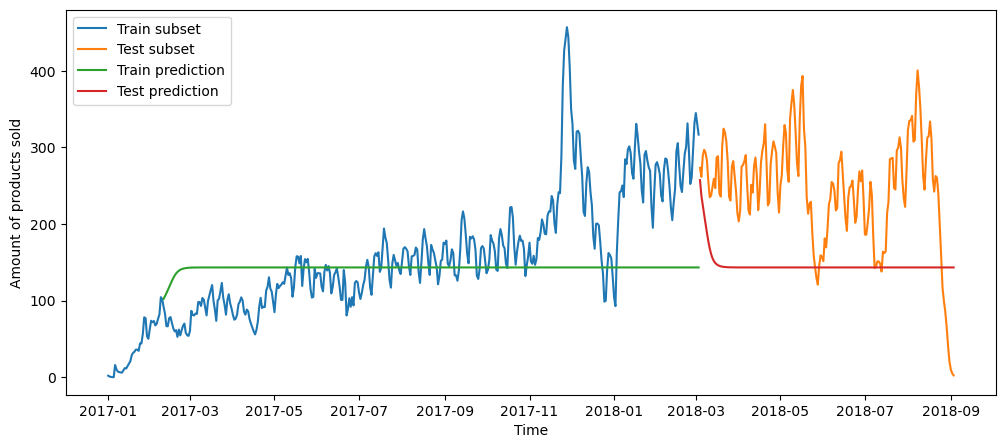

In [116]:
fig = plt.figure(figsize=(12, 5))
plt.plot(ts_train, label='Train subset')
plt.plot(ts_test, label='Test subset')
plt.plot(ts_train.index[lags:], train_predict, label='Train prediction')
plt.plot(ts_test.index, test_predict, label='Test prediction')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

In [117]:
print_metrics(ts_train[lags:], ts_test, train_predict, test_predict)

================== Train ==================
R^2 =  -0.0834136919242312
MSE =  6087.001143390872

================== Test ===================
MSE =  15039.703668270027


We still have too little data to train the neural network, so I don't see the point in continuing. Let's make a prediction for 21 days ahead using the LightGBM model - it showed the best result.

### 2.4. Forecasting:

Let's train the LGBM model on the entire time series and perform the prediction.

In [118]:
X_train2, y_train2 = get_dataset(res_ts, lags)

lgbmr2 = LGBMRegressor(
    boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.2, n_estimators=1000, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.15, random_state=42, n_jobs=4, importance_type='split'
).fit(X_train2, y_train2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7640
[LightGBM] [Info] Number of data points in the train set: 571, number of used features: 40
[LightGBM] [Info] Start training from score 192.197496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [119]:
forecast = get_prediction(lgbmr2, 21, ts_test[-lags:])

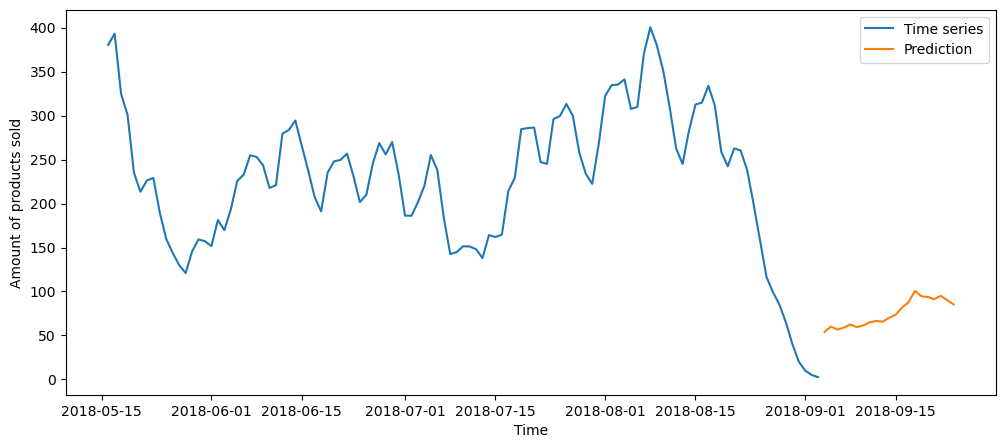

In [120]:
fig = plt.figure(figsize=(12, 5))
plt.plot(res_ts[500:], label='Time series')
plt.plot(pd.date_range(start=ts_test.index[-1], periods=22, freq='D')[1:], forecast, label='Prediction')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
plt.legend();

# Results:

Let's graph the forecast of the two best models: Sarimax and LightGBM:

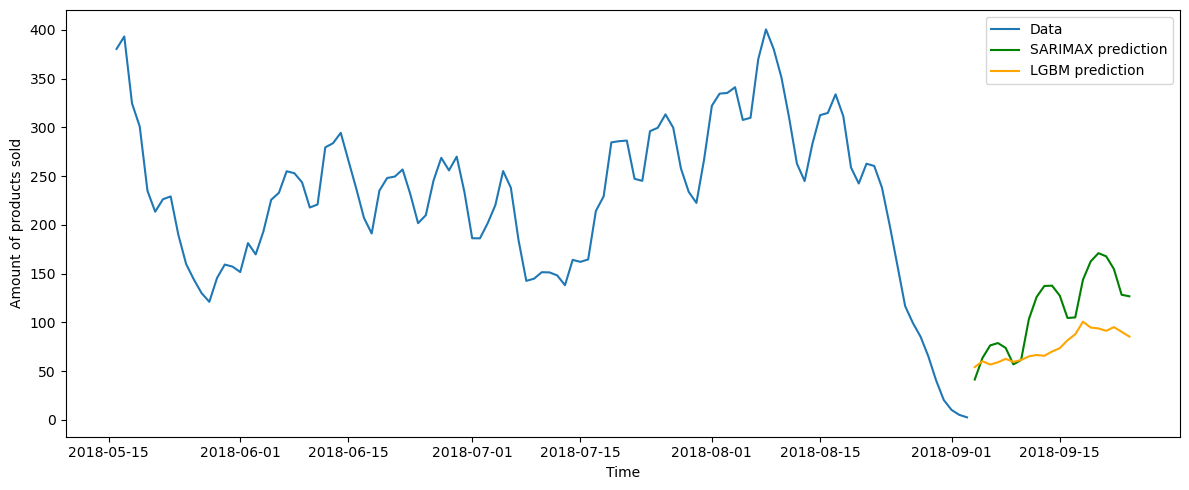

In [121]:
fig = plt.figure(figsize=(12, 5))
plt.plot(res_ts[500:], label='Data')
plt.plot(forecasted_values, color='green', label='SARIMAX prediction')
plt.plot(pd.date_range(start=ts_test.index[-1], periods=22, freq='D')[1:], forecast, color='orange', label='LGBM prediction')
plt.xlabel('Time')
plt.ylabel('Amount of products sold')
fig.tight_layout()
plt.legend();

# Conclusion:

As we can see, the forecasts turned out to be similar, but which one can be trusted? In this case, I would prefer the forecast of the SARIMAX model, as this model has accurately taken into account the seasonal parameters of the series, as well as all autocorrelation dependencies.